## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

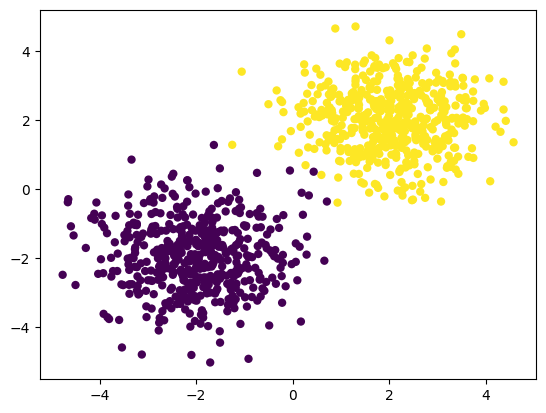

In [49]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [9]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [51]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [52]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

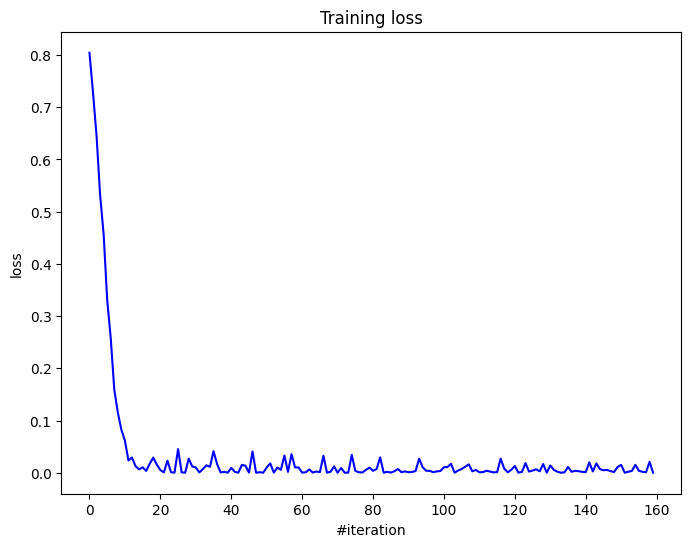

Current loss: 0.000041


In [53]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)    
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss) 

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [97]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [98]:
import numpy as np

def one_hot(y, num_classes=10):
    y = np.asarray(y)
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

In [99]:
y_train_oh = one_hot(y_train)
y_val_oh = one_hot(y_val)
y_test_oh = one_hot(y_test)

In [100]:
X_train_flat = X_train.reshape(X_train.shape[0], 28*28)
X_val_flat = X_val.reshape(X_val.shape[0], 28*28)
X_test_flat = X_test.reshape(X_test.shape[0], 28*28)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

### Определим в начале все нужные функии 

In [117]:
def batch_generator(X, y, batch_size=64, shuffle=True):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, n_samples, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]

In [191]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_loss_and_acc(train_loss_history, val_loss_history, val_acc_history):
    clear_output(wait=True)
    epochs = range(1, len(train_loss_history) + 1)
    plt.figure(figsize=(14, 5))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, label='Train Loss')
    plt.plot(epochs, val_loss_history, '--', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train / Validation Loss')
    plt.legend()
    plt.grid(True)

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_acc_history, label='Val Acc')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [119]:
def validate_model(net, criterion, X_val, y_val):
    # loss
    val_predictions = net.forward(X_val)
    val_loss = criterion.forward(val_predictions, y_val)

    # acc
    pred_classes = np.argmax(val_predictions, axis=1)
    true_classes = np.argmax(y_val, axis=1)
    val_acc = np.mean(pred_classes == true_classes)
    
    return val_loss, val_acc


In [ ]:
def train_net(
    net,
    X_train, y_train,
    X_val, y_val,
    optimizer,
    optimizer_config,
    optimizer_state,
    criterion,
    n_epoch,
    batch_size,
    plot_res=False
    ):
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    
    net.train()
    for epoch in range(n_epoch):
        epoch_train_losses = []
        for x_batch, y_batch in batch_generator(X_train, y_train, batch_size=batch_size):
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            optimizer(
                net.getParameters(), 
                net.getGradParameters(), 
                optimizer_config,
                optimizer_state
            )    
            
            epoch_train_losses.append(loss)
        
        train_loss_history.append(np.mean(epoch_train_losses))
    
        # validation
        net.evaluate()
        val_loss, val_acc = validate_model(net, criterion, X_val, y_val)
        net.train()

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        if plot_res:
            plot_loss_and_acc(
                train_loss_history,
                val_loss_history,
                val_acc_history
            )
    
    return train_loss_history, val_loss_history, val_acc_history

In [130]:
# Определяем размер входа и выхода
input_shape = X_train_flat.shape[-1]
output_shape = y_train_oh.shape[-1]

### Сравнение разной глубины FFN глубины

In [132]:
# depth = 1
net = Sequential()
net.add(Linear(input_shape, output_shape))
net.add(LogSoftMax())

criterion_mnist = ClassNLLCriterion()
optimizer_config_mnist = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state_mnist = {}


train_loss_1, val_loss_1, val_acc_1 = train_net(
    net=net,
    X_train=X_train_flat,
    y_train=y_train_oh,
    X_val=X_val_flat,
    y_val=y_val_oh,
    optimizer=sgd_momentum,
    optimizer_config=optimizer_config_mnist,
    optimizer_state=optimizer_state_mnist,
    criterion=criterion_mnist,
    n_epoch=10,
    batch_size=64
)

In [135]:
# depth = 2
net = Sequential()
net.add(Linear(input_shape, 256))
net.add(ReLU())
net.add(Linear(256, output_shape))
net.add(LogSoftMax())

criterion_mnist = ClassNLLCriterion()
optimizer_config_mnist = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state_mnist = {}


train_loss_2, val_loss_2, val_acc_2 = train_net(
    net=net,
    X_train=X_train_flat,
    y_train=y_train_oh,
    X_val=X_val_flat,
    y_val=y_val_oh,
    optimizer=sgd_momentum,
    optimizer_config=optimizer_config_mnist,
    optimizer_state=optimizer_state_mnist,
    criterion=criterion_mnist,
    n_epoch=10,
    batch_size=64
)

In [134]:
# depth = 3
net = Sequential()
net.add(Linear(input_shape, 512))
net.add(ReLU())
net.add(Linear(512, 256))
net.add(ReLU())
net.add(Linear(256, output_shape))
net.add(LogSoftMax())

criterion_mnist = ClassNLLCriterion()
optimizer_config_mnist = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state_mnist = {}


train_loss_3, val_loss_3, val_acc_3 = train_net(
    net=net,
    X_train=X_train_flat,
    y_train=y_train_oh,
    X_val=X_val_flat,
    y_val=y_val_oh,
    optimizer=sgd_momentum,
    optimizer_config=optimizer_config_mnist,
    optimizer_state=optimizer_state_mnist,
    criterion=criterion_mnist,
    n_epoch=10,
    batch_size=64
)

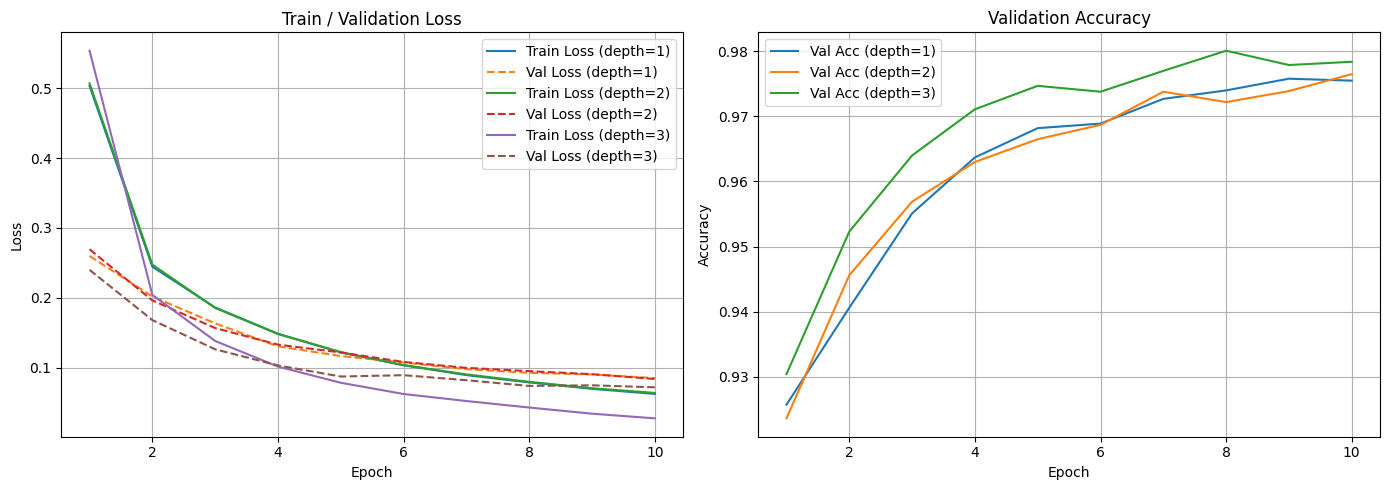

In [136]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_1) + 1)

plt.figure(figsize=(14, 5))

# ====== LOSS ======
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_1, label='Train Loss (depth=1)')
plt.plot(epochs, val_loss_1, '--', label='Val Loss (depth=1)')

plt.plot(epochs, train_loss_2, label='Train Loss (depth=2)')
plt.plot(epochs, val_loss_2, '--', label='Val Loss (depth=2)')

plt.plot(epochs, train_loss_3, label='Train Loss (depth=3)')
plt.plot(epochs, val_loss_3, '--', label='Val Loss (depth=3)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train / Validation Loss')
plt.legend()
plt.grid(True)

# ====== ACCURACY ======
plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc_1, label='Val Acc (depth=1)')
plt.plot(epochs, val_acc_2, label='Val Acc (depth=2)')
plt.plot(epochs, val_acc_3, label='Val Acc (depth=3)')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [138]:
print(f"Depth = 1: {val_acc_1[-1]}")
print(f"Depth = 2: {val_acc_2[-1]}")
print(f"Depth = 3: {val_acc_3[-1]}")

Depth = 1: 0.9755
Depth = 2: 0.9765
Depth = 3: 0.9784


Depth = 1: 0.9755

Depth = 2: 0.9765

Depth = 3: 0.9784

Видно, что чем больше глубина, тем больше итоговая точность модели. Конечно тут нужно было подбирать параметры отдельно для каждой модели, но кажется это оверкилл для дз. Еще отмечу, что бесконечно увеличивать глубину нельзя, так как на самом деле есть оптимально соотношение между количеством весом и количество данных, на которых мы обучаем модель.

*Далее будем использова модель глубины 3*

### Сравнение функций активаций

In [137]:
# ReLU

net = Sequential()
net.add(Linear(input_shape, 512))
net.add(ReLU())
net.add(Linear(512, 256))
net.add(ReLU())
net.add(Linear(256, output_shape))
net.add(LogSoftMax())

criterion_mnist = ClassNLLCriterion()
optimizer_config_mnist = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state_mnist = {}

train_loss_relu, val_loss_relu, val_acc_relu = train_net(
    net=net,
    X_train=X_train_flat,
    y_train=y_train_oh,
    X_val=X_val_flat,
    y_val=y_val_oh,
    optimizer=sgd_momentum,
    optimizer_config=optimizer_config_mnist,
    optimizer_state=optimizer_state_mnist,
    criterion=criterion_mnist,
    n_epoch=10,
    batch_size=64
)

In [ ]:
# LeakyReLU

net = Sequential()
net.add(Linear(input_shape, 512))
net.add(LeakyReLU(slope=0.01))
net.add(Linear(512, 256))
net.add(LeakyReLU(slope=0.01))
net.add(Linear(256, output_shape))
net.add(LogSoftMax())

criterion_mnist = ClassNLLCriterion()
optimizer_config_mnist = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state_mnist = {}

train_loss_lrelu, val_loss_lrelu, val_acc_lrelu = train_net(
    net=net,
    X_train=X_train_flat,
    y_train=y_train_oh,
    X_val=X_val_flat,
    y_val=y_val_oh,
    optimizer=sgd_momentum,
    optimizer_config=optimizer_config_mnist,
    optimizer_state=optimizer_state_mnist,
    criterion=criterion_mnist,
    n_epoch=10,
    batch_size=64
)

In [142]:
# ELU

net = Sequential()
net.add(Linear(input_shape, 512))
net.add(ELU(alpha=1.0))
net.add(Linear(512, 256))
net.add(ELU(alpha=1.0))
net.add(Linear(256, output_shape))
net.add(LogSoftMax())

criterion_mnist = ClassNLLCriterion()
optimizer_config_mnist = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state_mnist = {}

train_loss_elu, val_loss_elu, val_acc_elu = train_net(
    net=net,
    X_train=X_train_flat,
    y_train=y_train_oh,
    X_val=X_val_flat,
    y_val=y_val_oh,
    optimizer=sgd_momentum,
    optimizer_config=optimizer_config_mnist,
    optimizer_state=optimizer_state_mnist,
    criterion=criterion_mnist,
    n_epoch=10,
    batch_size=64
)

In [145]:
# SoftPlus

net = Sequential()
net.add(Linear(input_shape, 512))
net.add(SoftPlus())
net.add(Linear(512, 256))
net.add(SoftPlus())
net.add(Linear(256, output_shape))
net.add(LogSoftMax())

criterion_mnist = ClassNLLCriterion()
optimizer_config_mnist = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state_mnist = {}

train_loss_softplus, val_loss_softplus, val_acc_softplus = train_net(
    net=net,
    X_train=X_train_flat,
    y_train=y_train_oh,
    X_val=X_val_flat,
    y_val=y_val_oh,
    optimizer=sgd_momentum,
    optimizer_config=optimizer_config_mnist,
    optimizer_state=optimizer_state_mnist,
    criterion=criterion_mnist,
    n_epoch=10,
    batch_size=64
)

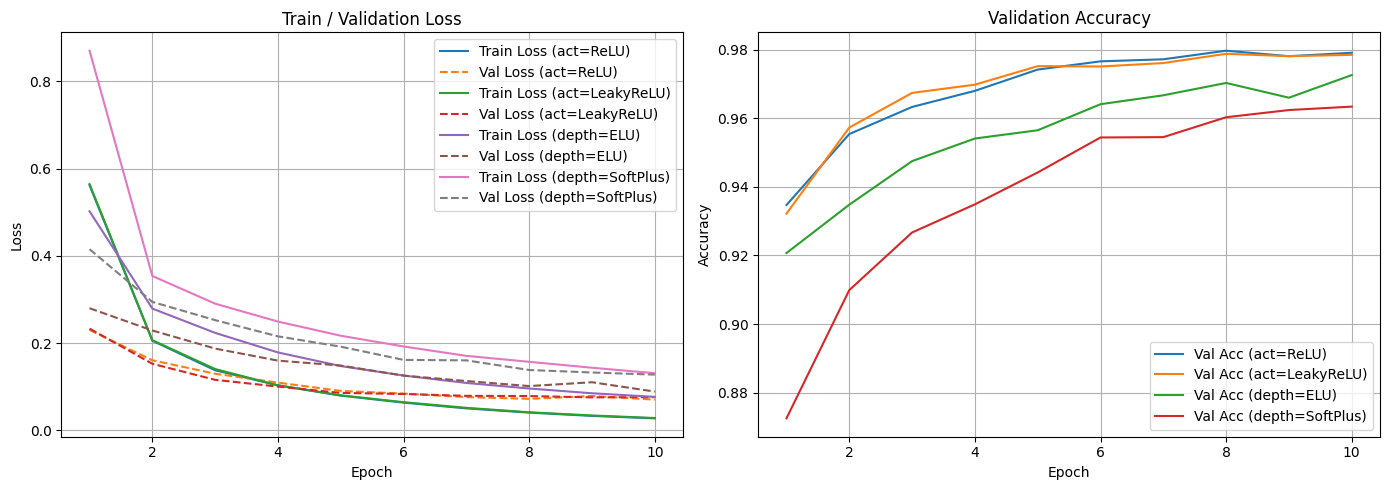

In [146]:
epochs = range(1, len(train_loss_1) + 1)

plt.figure(figsize=(14, 5))

# ====== LOSS ======
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_relu, label='Train Loss (act=ReLU)')
plt.plot(epochs, val_loss_relu, '--', label='Val Loss (act=ReLU)')

plt.plot(epochs, train_loss_lrelu, label='Train Loss (act=LeakyReLU)')
plt.plot(epochs, val_loss_lrelu, '--', label='Val Loss (act=LeakyReLU)')

plt.plot(epochs, train_loss_elu, label='Train Loss (depth=ELU)')
plt.plot(epochs, val_loss_elu, '--', label='Val Loss (depth=ELU)')

plt.plot(epochs, train_loss_softplus, label='Train Loss (depth=SoftPlus)')
plt.plot(epochs, val_loss_softplus, '--', label='Val Loss (depth=SoftPlus)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train / Validation Loss')
plt.legend()
plt.grid(True)

# ====== ACCURACY ======
plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc_relu, label='Val Acc (act=ReLU)')
plt.plot(epochs, val_acc_lrelu, label='Val Acc (act=LeakyReLU)')
plt.plot(epochs, val_acc_elu, label='Val Acc (depth=ELU)')
plt.plot(epochs, val_acc_softplus, label='Val Acc (depth=SoftPlus)')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [147]:
print(f"act ReLU: {val_acc_relu[-1]}")
print(f"act LeakyReLU: {val_acc_lrelu[-1]}")
print(f"act ELU: {val_acc_elu[-1]}")
print(f"act SoftPlus: {val_acc_softplus[-1]}")

act ReLU: 0.9791
act LeakyReLU: 0.9785
act ELU: 0.9726
act SoftPlus: 0.9634


act ReLU: 0.9791

act LeakyReLU: 0.9785

act ELU: 0.9726

act SoftPlus: 0.9634

В итоге, без подбора гиперпараметров судя по метрикам лучше всего себя показывает базовая ReLU, однако она очень близка с LeakReLU по accuracy. Думаю это результат того, что более сложные функции не дают заметного прироста в таких простых задачах.

### BatchNormalization

In [156]:
# Without BatchNormalization

net = Sequential()
net.add(Linear(input_shape, 512))
net.add(ReLU())
net.add(Linear(512, 256))
net.add(ReLU())
net.add(Linear(256, output_shape))
net.add(LogSoftMax())

criterion_mnist = ClassNLLCriterion()
optimizer_config_mnist = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state_mnist = {}

train_loss, val_loss, val_acc = train_net(
    net=net,
    X_train=X_train_flat,
    y_train=y_train_oh,
    X_val=X_val_flat,
    y_val=y_val_oh,
    optimizer=sgd_momentum,
    optimizer_config=optimizer_config_mnist,
    optimizer_state=optimizer_state_mnist,
    criterion=criterion_mnist,
    n_epoch=10,
    batch_size=128
)

In [157]:
# With BatchNormalization

net = Sequential()

net.add(Linear(input_shape, 512))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(512))
net.add(ReLU())

net.add(Linear(512, 256))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(256))
net.add(ReLU())

net.add(Linear(256, output_shape))
net.add(LogSoftMax())

criterion_mnist = ClassNLLCriterion()
optimizer_config_mnist = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state_mnist = {}

train_loss_bn, val_loss_bn, val_acc_bn = train_net(
    net=net,
    X_train=X_train_flat,
    y_train=y_train_oh,
    X_val=X_val_flat,
    y_val=y_val_oh,
    optimizer=sgd_momentum,
    optimizer_config=optimizer_config_mnist,
    optimizer_state=optimizer_state_mnist,
    criterion=criterion_mnist,
    n_epoch=10,
    batch_size=128
)

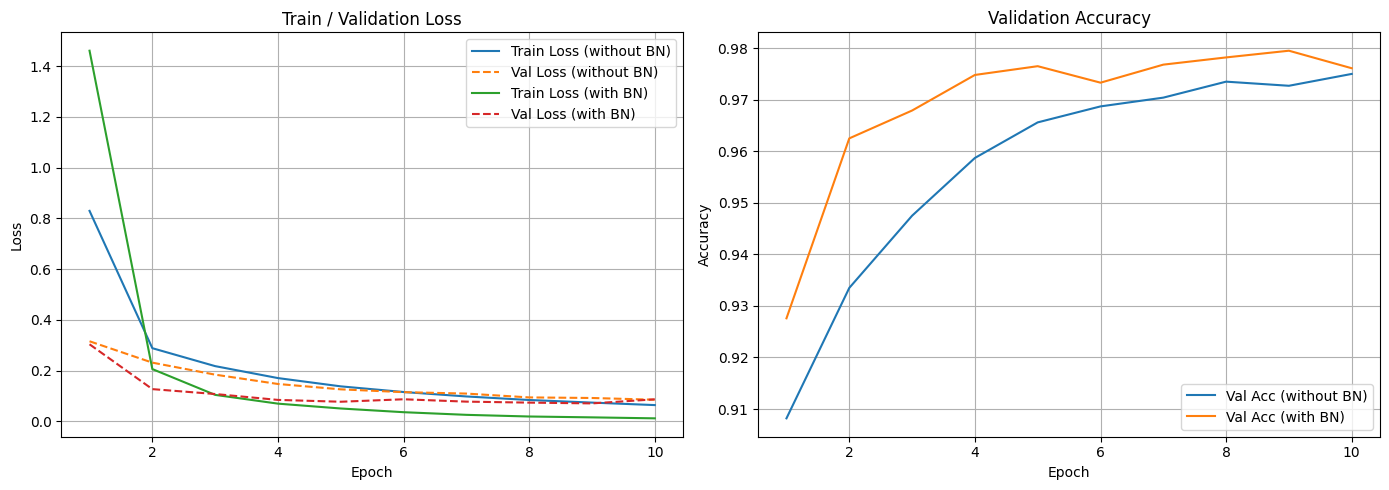

In [158]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))

# loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss (without BN)')
plt.plot(epochs, val_loss, '--', label='Val Loss (without BN)')

plt.plot(epochs, train_loss_bn, label='Train Loss (with BN)')
plt.plot(epochs, val_loss_bn, '--', label='Val Loss (with BN)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train / Validation Loss')
plt.legend()
plt.grid(True)

# accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, label='Val Acc (without BN)')
plt.plot(epochs, val_acc_bn, label='Val Acc (with BN)')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [160]:
print(f"Без батч нормализации: {val_acc[-1]}")
print(f"С батч нормализации: {val_acc_bn[-1]}")

Без батч нормализации: 0.975
С батч нормализации: 0.9761


В экспериментах на MNIST добавление Batch Normalization улучшило acc с 0.975 до 0.976. Кроме этого по графику лосса тоже видно улучшения. Стоит заметить, что при маленько батч сайзе(64) батч нормализация не давала таким преимуществ.

### Оптимизатор

In [165]:
# sgd momentum

net = Sequential()
net.add(Linear(input_shape, 512))
net.add(ReLU())
net.add(Linear(512, 256))
net.add(ReLU())
net.add(Linear(256, output_shape))
net.add(LogSoftMax())

criterion_mnist = ClassNLLCriterion()
optimizer_config_mnist = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state_mnist = {}

train_loss_momentum, val_loss_momentum, val_acc_momentum = train_net(
    net=net,
    X_train=X_train_flat,
    y_train=y_train_oh,
    X_val=X_val_flat,
    y_val=y_val_oh,
    optimizer=sgd_momentum,
    optimizer_config=optimizer_config_mnist,
    optimizer_state=optimizer_state_mnist,
    criterion=criterion_mnist,
    n_epoch=10,
    batch_size=128
)

In [178]:
# adam

net = Sequential()
net.add(Linear(input_shape, 512))
net.add(ReLU())
net.add(Linear(512, 256))
net.add(ReLU())
net.add(Linear(256, output_shape))
net.add(LogSoftMax())

criterion_mnist = ClassNLLCriterion()
optimizer_config_mnist = {'learning_rate' : 0.005, 'beta1': 0.9, 'beta2': 0.999, 'epsilon':1e-8 }
optimizer_state_mnist = {}

train_loss_adam, val_loss_adam, val_acc_adam = train_net(
    net=net,
    X_train=X_train_flat,
    y_train=y_train_oh,
    X_val=X_val_flat,
    y_val=y_val_oh,
    optimizer=adam_optimizer,
    optimizer_config=optimizer_config_mnist,
    optimizer_state=optimizer_state_mnist,
    criterion=criterion_mnist,
    n_epoch=10,
    batch_size=128
)

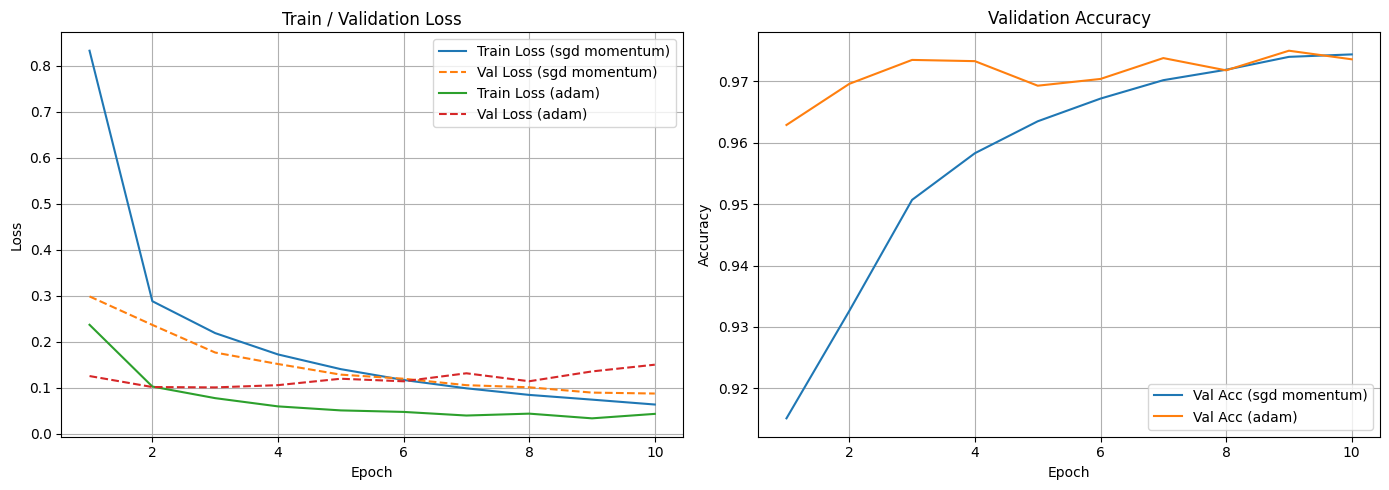

In [179]:
epochs = range(1, len(train_loss_momentum) + 1)

plt.figure(figsize=(14, 5))

# loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_momentum, label='Train Loss (sgd momentum)')
plt.plot(epochs, val_loss_momentum, '--', label='Val Loss (sgd momentum)')

plt.plot(epochs, train_loss_adam, label='Train Loss (adam)')
plt.plot(epochs, val_loss_adam, '--', label='Val Loss (adam)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train / Validation Loss')
plt.legend()
plt.grid(True)

# accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc_momentum, label='Val Acc (sgd momentum)')
plt.plot(epochs, val_acc_adam, label='Val Acc (adam)')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [180]:
print(f"sgd momentum: {val_acc_momentum[-1]}")
print(f"adam: {val_acc_adam[-1]}")

sgd momentum: 0.9744
adam: 0.9736


На данной задаче Adam значимого прироста в качестве не дает. Но по графику лосса видно насколько быстрее Adam позволяет сходиться лоссу

### Обучение финальной модели и замер качества

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Для финальной модели возьмем глубину 3, ReLU и Dropout и поставим побольше эпох

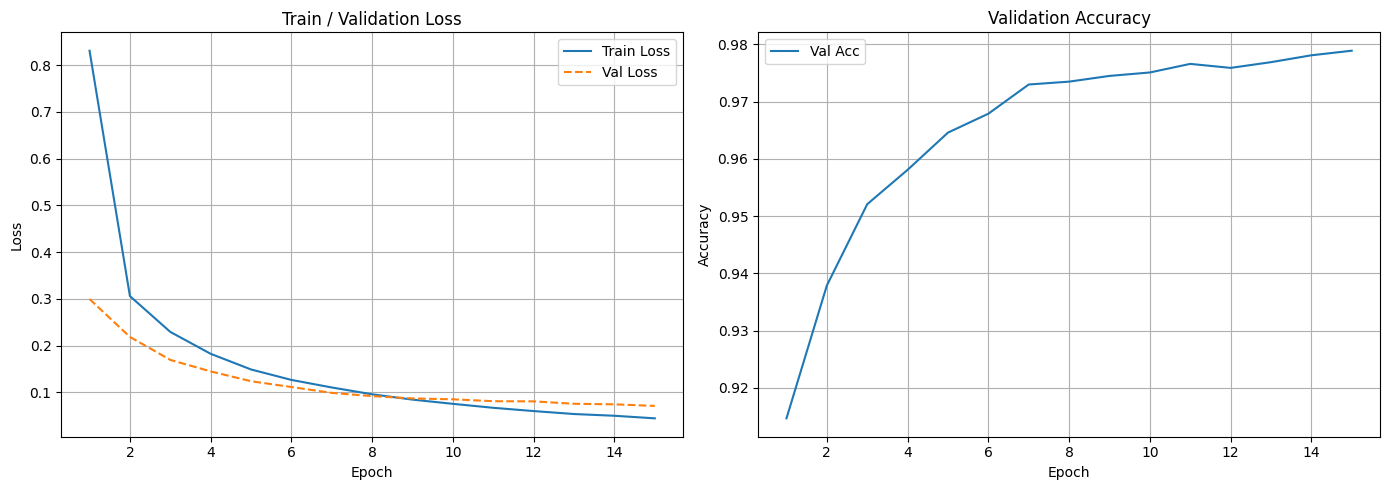

In [193]:
net = Sequential()
net.add(Linear(input_shape, 512))
net.add(ReLU())
net.add(Linear(512, 256))
net.add(ReLU())
net.add(Dropout(0.3))
net.add(Linear(256, output_shape))
net.add(LogSoftMax())

criterion_mnist = ClassNLLCriterion()
optimizer_config_mnist = {'learning_rate' : 0.005, 'momentum': 0.9}
optimizer_state_mnist = {}


train_loss, val_loss, val_acc = train_net(
    net=net,
    X_train=X_train_flat,
    y_train=y_train_oh,
    X_val=X_val_flat,
    y_val=y_val_oh,
    optimizer=sgd_momentum,
    optimizer_config=optimizer_config_mnist,
    optimizer_state=optimizer_state_mnist,
    criterion=criterion_mnist,
    n_epoch=15,
    batch_size=64,
    plot_res=True
)

In [194]:
print(f"Итоговая acc на val: {val_acc[-1]}")

Итоговая acc на val: 0.9789


Итоговая acc на val: 0.9789

Print here your accuracy on test set. It should be around 90%.

In [196]:
net.evaluate()
test_loss, test_acc = validate_model(net, criterion, X_test_flat, y_test_oh)

In [198]:
print(f"Итоговая acc на тесте: {test_acc}")

Итоговая acc на тесте: 0.9794


Итоговая acc на тесте: 0.9794

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__